# Thư Viện

In [ ]:
import numpy as np
import os
import keras
from pathlib import Path
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization ,Activation, Input,Rescaling
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer

(3630, 128, 128, 3)
(3630, 6)


<ipython-input-6-f37cfa6f9f51>:83: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  VggHist=VggModel.fit_generator(aug.flow(X_train, y_train, batch_size=64),


Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 10.0319 - accuracy: 0.8559
Epoch 1: val_accuracy improved from -inf to 0.97577, saving model to /content/drive/MyDrive/Colab Notebooks/Deep learning/doan/weights-01-0.98.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 39s 669ms/step - loss: 10.0319 - accuracy: 0.8559 - val_loss: 0.3651 - val_accuracy: 0.9758
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 1.5041 - accuracy: 0.9669
Epoch 2: val_accuracy improved from 0.97577 to 0.97687, saving model to /content/drive/MyDrive/Colab Notebooks/Deep learning/doan/weights-02-0.98.hdf5
57/57 [==============================] - 33s 570ms/step - loss: 1.5041 - accuracy: 0.9669 - val_loss: 1.3718 - val_accuracy: 0.9769
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 1.6609 - accuracy: 0.9694
Epoch 3: val_accuracy improved from 0.97687 to 0.98789, saving model to /content/drive/MyDrive/Colab Notebooks/Deep learning/doan/weights-03-0.99.hdf5
57/57 [==============================] - 32s 561ms/step - loss: 1.6609 - accuracy: 0.9694 - val_loss: 0.3855 - val_accuracy: 0.9879
Epoch 4/100
57/57 [==============================] - ETA: 0s - loss: 1.4202 - accuracy: 0.9738
Epoch 4: val_acc

TypeError: 10.0 must be a sequence

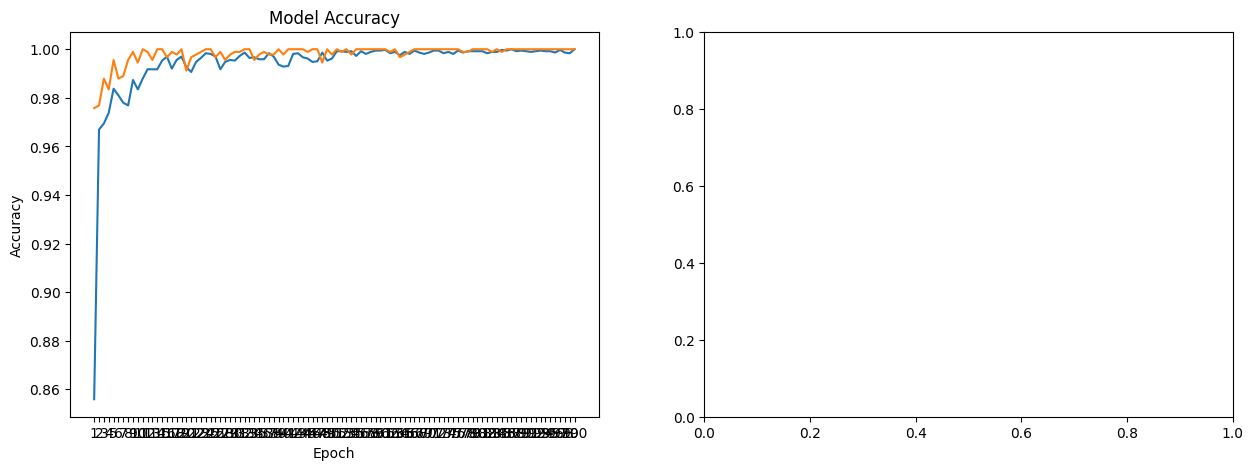

In [ ]:
raw_folder = "/content/drive/MyDrive/Colab Notebooks/Deep learning/doan/data/"
def save_data(raw_folder=raw_folder):

    print("Bắt đầu xử lý ảnh...")

    pixels = []
    labels = []

    for folder in listdir(raw_folder):
        if folder!='.DS_Store':
            print("Folder=",folder)
            for file in listdir(raw_folder  + folder):
                if file!='.DS_Store':
                    print("File=", file)
                    pixels.append( cv2.resize(cv2.imread(raw_folder  + folder +"/" + file),dsize=(128,128)))
                    labels.append( folder)

    pixels = np.array(pixels)
    labels = np.array(labels)

    encoder = LabelBinarizer()
    labels = encoder.fit_transform(labels)
    print(labels)

    file = open('/content/drive/MyDrive/Colab Notebooks/Deep learning/doan/pix.data', 'wb')
    pickle.dump((pixels,labels), file)
    file.close()

    return

def load_data():
    file = open('/content/drive/MyDrive/Colab Notebooks/Deep learning/doan/pix.data', 'rb')
    (pixels, labels) = pickle.load(file)
    file.close()

    return pixels, labels

# save_data()
X,y = load_data()
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=100)

print(X_train.shape)
print(y_train.shape)

def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    input = Input(shape=(128, 128, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(6, activation='softmax', name='predictions')(x)

    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return my_model

VggModel = get_model()

filepath="/content/drive/MyDrive/Colab Notebooks/Deep learning/doan/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    rescale= None,
	width_shift_range=0.1,
    height_shift_range=0.1,
	horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

aug_val = ImageDataGenerator(rescale=1./255)

hist = VggModel.fit_generator(aug.flow(X_train, y_train, batch_size=64),
                               epochs=100,
                               validation_data=aug.flow(X_test, y_test, batch_size=64),
                               callbacks=callbacks_list)

VggModel.save("/content/drive/MyDrive/Colab Notebooks/Deep learning/doan/VggModel.h5")

train_loss, val_loss = hist.history['loss'], hist.history['val_loss']
train_acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8, 3),nrows =1, ncols=2)

num_epoch = np.arange(len(train_loss))
ax[0].plot(num_epoch,train_loss)
ax[0].plot(num_epoch, val_loss)
ax[0].set_title('Model Loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train'],['validation'],loc='upper right')

ax[1].plot(num_epoch,train_acc)
ax[1].plot(num_epoch, val_acc)
ax[1].set_title(' Model accuracy')
ax[1].set_ylabel('acc')
ax[1].set_xlabel('epoch')
ax[1].legend(['train'],['validation'],loc='upper right')

plt.tight_layout()
plt.show()

# Data


In [ ]:
BASE_PATH = "/content/drive/MyDrive/ColabNotebooks/Deeplearning/doan/data"
TRAIN_PATH = '/content/drive/MyDrive/ColabNotebooks/Deeplearning/doan/data/train'
VALID_PATH = '/content/drive/MyDrive/ColabNotebooks/Deeplearning/doan/data/valid'
TEST_PATH = '/content/drive/MyDrive/ColabNotebooks/Deeplearning/doan/data/test'
CLASSES = ['cat', 'dog']

train_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / TRAIN_PATH ,
 image_size=(224, 224),
 batch_size=32,
 label_mode='categorical',
 shuffle=True,
 class_names=CLASSES,
 seed=12,
 color_mode='rgb')

validation_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / VALID_PATH ,
 image_size=(224, 224),
 batch_size=32,
 label_mode='categorical',
 shuffle=True,
 class_names=CLASSES,
 seed=12,
 color_mode='rgb')
test_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / TEST_PATH ,
 image_size=(224, 224),
 batch_size=32,
 label_mode='categorical',
 class_names=CLASSES,
 color_mode='rgb')

for images_batch, labels_batch in train_dataset:
  print(f'images batch shape: {images_batch.shape}')
  print(f'labels batch shape: {labels_batch.shape}')
  break

# **Model MLP**

In [ ]:
MLP = Sequential()
MLP.add(Flatten(input_shape=(224,224,3)))
MLP.add(Dense(256, activation='relu'))
MLP.add(Dense(128, activation='relu'))
MLP.add(Dense(3, activation='softmax'))

MLP.summary()

In [ ]:
adam = Adam()
MLP.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint(
 filepath="MLP.h5",
 save_best_only=True,
 save_weight_only=True,
 monitor="val_loss")
]

hist_MLP = MLP.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

In [ ]:
train_loss, val_loss = hist_MLP.history['loss'], hist_MLP.history['val_loss']
train_acc, val_acc = hist_MLP.history['accuracy'], hist_MLP.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8, 3),nrows =1, ncols=2)

num_epoch = np.arange(len(train_loss))
ax[0].plot(num_epoch,train_loss)
ax[0].plot(num_epoch, val_loss)
ax[0].set_title('Model Loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train'],['validation'],loc='upper right')

ax[1].plot(num_epoch,train_acc)
ax[1].plot(num_epoch, val_acc)
ax[1].set_title(' Model accuracy')
ax[1].set_ylabel('acc')
ax[1].set_xlabel('epoch')
ax[1].legend(['train'],['validation'],loc='upper right')

plt.tight_layout()
plt.show()

# **Model CNN**

In [ ]:
CNN = Sequential()
CNN.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',input_shape=(224, 224, 3), name='Conv2D_1'))
CNN.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_2'))
CNN.add(MaxPooling2D(pool_size=(2,2)))

CNN.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
CNN.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_4'))
CNN.add(MaxPooling2D(pool_size=(2,2)))

CNN.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_5'))
CNN.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_6'))
CNN.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_7'))
CNN.add(MaxPooling2D(pool_size=(2,2)))

CNN.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_8'))
CNN.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_9'))
CNN.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_10'))
CNN.add(MaxPooling2D(pool_size=(2,2)))

CNN.add(Flatten(name='Flatten'))

CNN.add(Dense(256, activation='relu',name='FC_1'))
CNN.add(Dropout(0.5))

CNN.add(Dense(128, activation='relu',name='FC_2'))
CNN.add(Dropout(0.5))

CNN.add(Dense(3, activation='softmax',name='FC_3'))

CNN.summary()

In [ ]:
adam = Adam()
CNN.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint(
 filepath="CNN.h5",
 save_best_only=True,
 save_weight_only=True,
 monitor="val_loss")
]

hist_CNN = CNN.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

In [ ]:
train_loss, val_loss = hist_CNN.history['loss'], hist_CNN.history['val_loss']
train_acc, val_acc = hist_CNN.history['accuracy'], hist_CNN.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8, 3),nrows =1, ncols=2)

num_epoch = np.arange(len(train_loss))
ax[0].plot(num_epoch,train_loss)
ax[0].plot(num_epoch, val_loss)
ax[0].set_title('Model Loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train'],['validation'],loc='upper right')

ax[1].plot(num_epoch,train_acc)
ax[1].plot(num_epoch, val_acc)
ax[1].set_title(' Model accuracy')
ax[1].set_ylabel('acc')
ax[1].set_xlabel('epoch')
ax[1].legend(['train'],['validation'],loc='upper right')

plt.tight_layout()
plt.show()

# **Model VGG16 (Không transfer Learning)**

In [ ]:
VGG16 = Sequential()
# Khối VGG 1
VGG16.add(Conv2D(filters=64,kernel_size=3, padding = 'same', input_shape = (224,224,3), activation='relu'))
VGG16.add(Conv2D(filters=64,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(MaxPooling2D(pool_size=2, strides=2))
# Khối VGG 2
VGG16.add(Conv2D(filters=128,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(Conv2D(filters=128,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(MaxPooling2D(pool_size=2, strides=2))
# Khối VGG 3
VGG16.add(Conv2D(filters=256,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(Conv2D(filters=256,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(Conv2D(filters=256,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(MaxPooling2D(pool_size=2, strides=2))
# Khối VGG 4
VGG16.add(Conv2D(filters=512,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(Conv2D(filters=512,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(Conv2D(filters=512,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(MaxPooling2D(pool_size=2, strides=2))
# Khối VGG 5
VGG16.add(Conv2D(filters=512,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(Conv2D(filters=512,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(Conv2D(filters=512,kernel_size=3, padding = 'same', activation='relu'))
VGG16.add(MaxPooling2D(pool_size=2, strides=2))

VGG16.add(Flatten())

# fully connected layer
VGG16.add(Dense(units=4096,activation='relu'))
VGG16.add(Dropout(0.5))
VGG16.add(Dense(units=4096,activation='relu'))
VGG16.add(Dropout(0.5))
VGG16.add(Dense(units=6,activation='softmax'))

In [ ]:
adam = Adam()
VGG16.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint(
 filepath="VGG16.h5",
 save_best_only=True,
 save_weight_only=True,
 monitor="val_loss")
]

hist_VGG16 = VGG16.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

In [ ]:
train_loss, val_loss = hist_VGG16.history['loss'], hist_VGG16.history['val_loss']
train_acc, val_acc = hist_VGG16.history['accuracy'], hist_VGG16.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8, 3),nrows =1, ncols=2)

num_epoch = np.arange(len(train_loss))
ax[0].plot(num_epoch,train_loss)
ax[0].plot(num_epoch, val_loss)
ax[0].set_title('Model Loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train'],['validation'],loc='upper right')

ax[1].plot(num_epoch,train_acc)
ax[1].plot(num_epoch, val_acc)
ax[1].set_title(' Model accuracy')
ax[1].set_ylabel('acc')
ax[1].set_xlabel('epoch')
ax[1].legend(['train'],['validation'],loc='upper right')

plt.tight_layout()
plt.show()

# **Model VGG16 (Có transfer Learning)**

In [ ]:
def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    input = Input(shape=(128, 128, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(6, activation='softmax', name='predictions')(x)

    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return my_model


In [ ]:
VggModel = get_model()

filepath="/content/drive/MyDrive/Colab Notebooks/Deep learning/doan/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    rescale= None,
	width_shift_range=0.1,
    height_shift_range=0.1,
	horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

aug_val = ImageDataGenerator(rescale=1./255)

hist = VggModel.fit_generator(aug.flow(train_dataset, batch_size=64),
                               epochs=100,
                               validation_data=aug.flow(validation_dataset, batch_size=64),
                               callbacks=callbacks_list)

VggModel.save("/content/drive/MyDrive/Colab Notebooks/Deep learning/doan/VggModel.h5")


In [ ]:
train_loss, val_loss = hist.history['loss'], hist.history['val_loss']
train_acc, val_acc = hist.history['accuracy'], hist.history['val_accuracy']

fig, ax = plt.subplots(figsize=(8, 3),nrows =1, ncols=2)

num_epoch = np.arange(len(train_loss))
ax[0].plot(num_epoch,train_loss)
ax[0].plot(num_epoch, val_loss)
ax[0].set_title('Model Loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train'],['validation'],loc='upper right')

ax[1].plot(num_epoch,train_acc)
ax[1].plot(num_epoch, val_acc)
ax[1].set_title(' Model accuracy')
ax[1].set_ylabel('acc')
ax[1].set_xlabel('epoch')
ax[1].legend(['train'],['validation'],loc='upper right')

plt.tight_layout()
plt.show()

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory
from pathlib import Path

BASE_PATH = "E:\\daihoc\\nam_3_ky_2\\Deeplearning\\Universities-Logos-Detection\\data"
TEST_PATH = 'E:\\daihoc\\nam_3_ky_2\\Deeplearning\\Universities-Logos-Detection\\data\\test'
CLASSES = ['00000', 'BKHCM','DHQG','HUFLIT','UEB','USSH']

test_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / TEST_PATH ,
 image_size=(128, 128),
 batch_size=32,
 label_mode='categorical',
 class_names=CLASSES,
 color_mode='rgb')

Found 768 files belonging to 6 classes.


In [13]:
import keras
test_model = keras.models.load_model("VggModel.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 24s 946ms/step - loss: 111.2273 - accuracy: 0.5560
Test accuracy: 0.556
